In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import gc
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import json
import urllib
from datetime import datetime, timedelta,timezone
import requests

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
btc = pd.read_csv('/content/Bitcoin History.csv')
btc.head()

Date     Price      Open      High       Low    Vol. Change %
0  Feb 09, 2024  47,545.4  45,293.3  47,710.2  45,254.2  86.85K    4.97%
1  Feb 08, 2024  45,293.3  44,346.2  45,579.2  44,336.4  66.38K    2.15%
2  Feb 07, 2024  44,339.8  43,088.4  44,367.9  42,783.5  48.57K    2.91%
3  Feb 06, 2024  43,087.7  42,697.6  43,375.5  42,566.8  33.32K    0.91%
4  Feb 05, 2024  42,697.2  42,581.4  43,532.2  42,272.5  39.26K    0.27%

# Data preprocessing
Let's resample the data, take only the variable we're going to use and determine what's the window of data that's more meaningful for our purpose. Let's also clean null values.

In [3]:
btc['Date'] = pd.to_datetime(btc.Date, format='%b %d, %Y')
btc.head()

Date     Price      Open      High       Low    Vol. Change %
0 2024-02-09  47,545.4  45,293.3  47,710.2  45,254.2  86.85K    4.97%
1 2024-02-08  45,293.3  44,346.2  45,579.2  44,336.4  66.38K    2.15%
2 2024-02-07  44,339.8  43,088.4  44,367.9  42,783.5  48.57K    2.91%
3 2024-02-06  43,087.7  42,697.6  43,375.5  42,566.8  33.32K    0.91%
4 2024-02-05  42,697.2  42,581.4  43,532.2  42,272.5  39.26K    0.27%

In [4]:
print('Minutes in dataset: ',len(btc))
print('Hours in dataset: ',len(btc)/60)
print('Days in dataset: ',len(btc)/60/24)

Minutes in dataset:  4955
Hours in dataset:  82.58333333333333
Days in dataset:  3.440972222222222


In [5]:
btc = btc[['Date','Price']]
btc.head()

Date     Price
0 2024-02-09  47,545.4
1 2024-02-08  45,293.3
2 2024-02-07  44,339.8
3 2024-02-06  43,087.7
4 2024-02-05  42,697.2

In [6]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4955 entries, 0 to 4954
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4955 non-null   datetime64[ns]
 1   Price   4955 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 77.5+ KB


In [7]:
btc['Price'] = pd.to_numeric(btc['Price'], errors='coerce')

btc = btc.resample('H', on='Date')[['Price']].mean()

<ipython-input-7-c12495147ed3>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  btc = btc.resample('H', on='Date')[['Price']].mean()


In [8]:
    pano = btc.copy()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pano.index, y=pano['Price'],name='Full history BTC price'))
    fig.update_layout(showlegend=True,title="BTC price history",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
    fig.show()

In [9]:
import pandas as pd
btc['Price'] = btc['Price'].ffill()

In [10]:
print('Starting date selected: ',btc.index[51000])
print('NaN values: ',btc.iloc[51000:].isna().sum())

Starting date selected:  2016-05-12 00:00:00
NaN values:  Price    0
dtype: int64


# Data Splitting
We're going to take the test set as the first 20% window. The next 80s as the training set.

In [11]:
data_for_us = btc.copy()
training_start = int(len(btc) * 0.2)

train = btc.iloc[training_start:]
test = btc.iloc[:training_start]
print("Total datasets' lenght: ",train.shape, test.shape)

Total datasets' lenght:  (95118, 1) (23779, 1)


# Data scaling

This stage is extremely important as a requisite to train Neural Networks. If you skip this step maybe your model won't converge.

In [12]:
scaler = MinMaxScaler().fit(train[['Price']])

In [13]:
def scale_samples(data,column_name,scaler):
    data[column_name] = scaler.transform(data[[column_name]])
    return data

In [14]:
joblib.dump(scaler, 'scaler.gz')
scaler = joblib.load('scaler.gz')

In [15]:
train = scale_samples(train.copy(),train.columns[0],scaler)
train.head()

Price
Date                         
2013-04-03 19:00:00  0.071675
2013-04-03 20:00:00  0.071675
2013-04-03 21:00:00  0.071675
2013-04-03 22:00:00  0.071675
2013-04-03 23:00:00  0.071675

In [16]:
test = scale_samples(test,test.columns[0],scaler)
test.head()

<ipython-input-13-18c308a0a5e2>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Price
Date                         
2010-07-18 00:00:00 -0.073504
2010-07-18 01:00:00 -0.073504
2010-07-18 02:00:00 -0.073504
2010-07-18 03:00:00 -0.073504
2010-07-18 04:00:00 -0.073504

# Sequences generation and dataset creation

In [17]:
def shift_samples(data,column_name,lookback=24):
    """This function takes a *data* dataframe and returns two numpy arrays:
    - X corresponds to the same values but packed into n frames of *lookback* values each
    - Y corresponds to the sample shifted *lookback* steps to the future
    """
    data_x = []
    data_y = []
    for i in range(len(data) - int(lookback)):
        x_floats = np.array(data.iloc[i:i+lookback])
        y_floats = np.array(data.iloc[i+lookback])
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y)

In [18]:
X_train, y_train = shift_samples(train[['Price']],train.columns[0])
X_test, y_test = shift_samples(test[['Price']], test.columns[0])
gc.collect()

24

In [19]:
print("Final datasets' shapes:")
print('X_train: '+str(X_train.shape)+', y_train: '+str(y_train.shape))
print('X_test: '+str(X_test.shape)+', y_train: '+str(y_test.shape))

Final datasets' shapes:
X_train: (95094, 24, 1), y_train: (95094, 1)
X_test: (23755, 24, 1), y_train: (23755, 1)


In [20]:
tsteps = X_train.shape[1]
nfeatures = X_train.shape[2]

# Anomaly detectors' training
## LSTM Autoencoder Neural Network

The one that we'll be using along this notebook.

In [21]:
#First model - LSTM Autoencoder for anomaly detections

detector = Sequential()
detector.add(layers.LSTM(128, input_shape=(tsteps, nfeatures),dropout=0.2))
detector.add(layers.Dropout(rate=0.5))
detector.add(layers.RepeatVector(tsteps))
detector.add(layers.LSTM(128, return_sequences=True,dropout=0.2))
detector.add(layers.Dropout(rate=0.5))
detector.add(layers.TimeDistributed(layers.Dense(nfeatures)))

detector.compile(loss='mae', optimizer='adam')
detector.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 24, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("/kaggle/working/detector.keras",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='auto',
                            save_freq='epoch')
history1 = detector.fit(X_train, y_train,
                        epochs=20,
                        batch_size=256,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[checkpoint],
                        shuffle=False)


Epoch 1/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 0.0945
Epoch 1: val_loss improved from inf to 0.00538, saving model to /kaggle/working/detector.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 125s 361ms/step - loss: 0.0944 - val_loss: 0.0054
Epoch 2/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.2383
Epoch 2: val_loss did not improve from 0.00538
335/335 ━━━━━━━━━━━━━━━━━━━━ 126s 315ms/step - loss: 0.2382 - val_loss: 0.0415
Epoch 3/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2827
Epoch 3: val_loss did not improve from 0.00538
335/335 ━━━━━━━━━━━━━━━━━━━━ 140s 309ms/step - loss: 0.2824 - val_loss: 0.0365
Epoch 4/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.2669
Epoch 4: val_loss did not improve from 0.00538
335/335 ━━━━━━━━━━━━━━━━━━━━ 183s 432ms/step - loss: 0.2665 - val_loss: 0.0060
Epoch 5/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2236
Epoch 5: val_loss improved from 0.00538 to 0.00153, saving model to /kaggle/working/detector.keras
335/

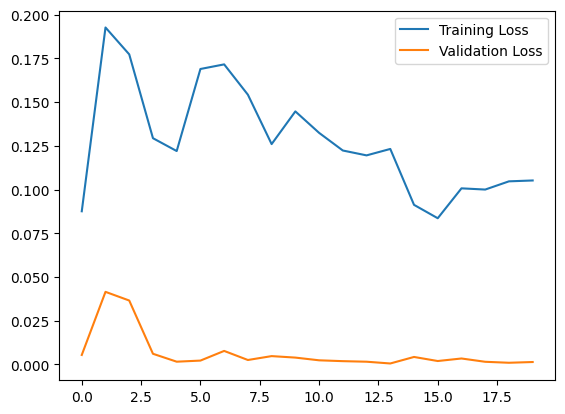

In [23]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()

In [26]:
from tensorflow.keras.models import load_model

detector = load_model("/kaggle/working/detector.keras")
detector.evaluate(X_test, y_test)

743/743 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 1.0395


1.0337398052215576

### Determining threshold for Autoencoder detector

2972/2972 ━━━━━━━━━━━━━━━━━━━━ 77s 26ms/step


<ipython-input-27-f480f79ef5fb>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

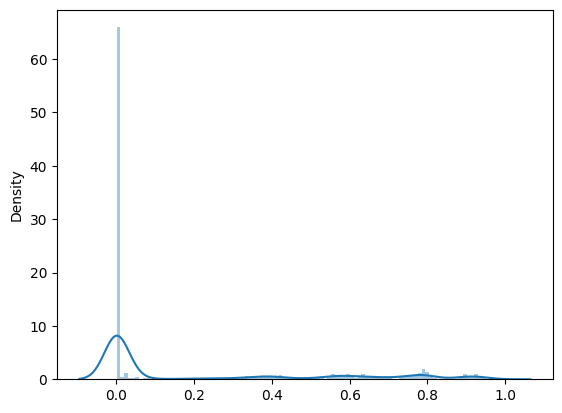

In [27]:
X_train_pred = detector.predict(X_train)
loss_mae = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.distplot(loss_mae, bins=100, kde=True)

743/743 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step


<ipython-input-28-0196ad193d8e>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

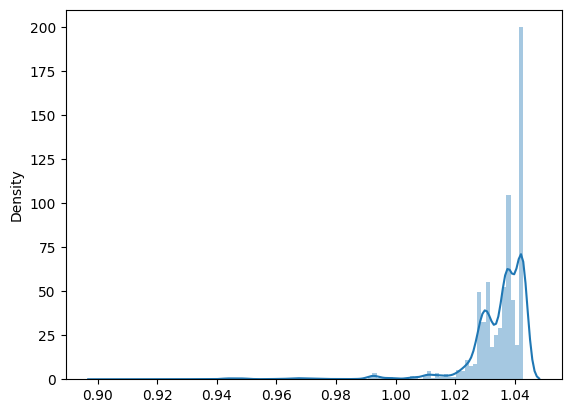

In [28]:
X_test_pred = detector.predict(X_test)
loss_mae = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(loss_mae, bins=100, kde=True)

In [29]:
threshold = 0.15

test_df = pd.DataFrame(test[tsteps:])
test_df['loss'] = loss_mae
test_df['threshold'] = threshold
test_df['anomaly'] = test_df.loss > test_df.threshold
test_df['Price'] = test[tsteps:].Price

### Plotting prices' anomalies

In [30]:
anomalies = test_df[test_df.anomaly == True]
anomalies.head()

Price      loss  threshold  anomaly
Date                                                       
2010-07-19 00:00:00 -0.073504  1.042822       0.15     True
2010-07-19 01:00:00 -0.073504  1.042822       0.15     True
2010-07-19 02:00:00 -0.073504  1.042822       0.15     True
2010-07-19 03:00:00 -0.073504  1.042822       0.15     True
2010-07-19 04:00:00 -0.073504  1.042822       0.15     True

In [31]:
yvals1 = scaler.inverse_transform(test[tsteps:][['Price']])
yvals1 = yvals1.reshape(-1)

In [32]:
yvals2 = scaler.inverse_transform(anomalies[['Price']])
yvals2 = yvals2.reshape(-1)

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[tsteps:].index, y=yvals1,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=anomalies.index, y=yvals2,mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True,title="BTC price anomalies",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

In [35]:
import pandas as pd

scaled_pano = pd.concat([test, train], ignore_index=False) # Use pd.concat instead of append
X_shifted, y_shifted = shift_samples(scaled_pano[['Price']], scaled_pano.columns[0])
print("Scaled pano datasets' shapes:")
print('X_shifted: '+str(X_shifted.shape)+', y_shifted: '+str(y_shifted.shape))

Scaled pano datasets' shapes:
X_shifted: (118873, 24, 1), y_shifted: (118873, 1)


In [36]:
X_shifted_pred = detector.predict(X_shifted)
loss_mae = np.mean(np.abs(X_shifted_pred - X_shifted), axis=1)

3715/3715 ━━━━━━━━━━━━━━━━━━━━ 95s 26ms/step


In [37]:
non_scaled_pano = pano.copy()[51000:]
non_scaled_pano.fillna(method ='bfill', inplace = True)
non_scaled_pano = non_scaled_pano[:-24]

<ipython-input-37-e69ad51a791d>:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [40]:
loss_mae_series = pd.Series(loss_mae.flatten(), index=pd.RangeIndex(len(loss_mae)))
loss_mae_series = loss_mae_series.reindex(scaled_pano.index, fill_value=np.nan)
loss_mae_filtered = loss_mae_series[loss_mae_series.index.isin(non_scaled_pano.index)]
non_scaled_pano['loss_mae'] = loss_mae_filtered.values

non_scaled_pano['threshold'] = threshold
non_scaled_pano['anomaly'] = non_scaled_pano.loss_mae > non_scaled_pano.threshold
non_scaled_pano.head()

Price  loss_mae  threshold  anomaly
Date                                                    
2016-05-12 00:00:00  454.4       NaN       0.15    False
2016-05-12 01:00:00  455.4       NaN       0.15    False
2016-05-12 02:00:00  455.4       NaN       0.15    False
2016-05-12 03:00:00  455.4       NaN       0.15    False
2016-05-12 04:00:00  455.4       NaN       0.15    False

In [41]:
pano_outliers = non_scaled_pano[non_scaled_pano['anomaly'] == True]

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=non_scaled_pano.index, y=non_scaled_pano['Price'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=pano_outliers.index, y=pano_outliers['Price'].values,mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True,title="BTC price anomalies - Autoencoder",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

##Isolation forest model

In [44]:

outliers = pano.copy()[51000:]
outliers['Price'].fillna(method='bfill', inplace=True)
outliers['Price'].fillna(method='ffill', inplace=True)  #
isolation_detector = IsolationForest(n_estimators=150, random_state=0, contamination='auto')
isolation_detector.fit(outliers['Price'].values.reshape(-1, 1))

<ipython-input-44-68d39b20f6f1>:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-44-68d39b20f6f1>:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-44-68d39b20f6f1>:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

IsolationForest(n_estimators=150, random_state=0)

In [45]:
data_ready = np.linspace(outliers['Price'].min(), outliers['Price'].max(), len(outliers)).reshape(-1,1)
outlier = isolation_detector.predict(data_ready)

In [46]:
outliers['outlier'] = outlier
outliers.head()

Price  outlier
Date                               
2016-05-12 00:00:00  454.4       -1
2016-05-12 01:00:00  455.4       -1
2016-05-12 02:00:00  455.4       -1
2016-05-12 03:00:00  455.4       -1
2016-05-12 04:00:00  455.4       -1

#Plotting prices' anomalies

In [47]:
a = outliers.loc[outliers['outlier'] == 1] #anomaly
fig = go.Figure()
fig.add_trace(go.Scatter(x=outliers['Price'].index, y=outliers['Price'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=a.index, y=a['Price'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=2))
fig.update_layout(showlegend=True,title="BTC price anomalies - IsolationForest",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()